In [1]:
%load_ext autoreload
%autoreload 2

from cluster_g_logit_init_acceptpsi import *


%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()



Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_31683/1069408875.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [2]:

def subset_data(Y, E, G, n_samples=50000, seed=42):
    """
    Subset the data to n_samples individuals while maintaining consistency
    
    Args:
        Y: tensor of shape [N, D, T]
        E: tensor of shape [N, D]
        G: tensor of shape [N, P]
        n_samples: number of individuals to keep
        seed: random seed for reproducibility
    
    Returns:
        Y_sub, E_sub, G_sub: subsetted tensors
    """
    torch.manual_seed(seed)
    
    # Get total number of individuals
    N = Y.shape[0]
    
    # Randomly select n_samples indices
    indices = torch.randperm(N)[:n_samples]
    
    # Subset all matrices using the same indices
    Y_sub = Y[indices]
    E_sub = E[indices]
    G_sub = G[indices]
    
    print(f"Original shapes: Y={Y.shape}, E={E.shape}, G={G.shape}")
    print(f"New shapes: Y={Y_sub.shape}, E={E_sub.shape}, G={G_sub.shape}")
    
    return Y_sub, E_sub, G_sub, indices

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, n_samples=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data


Original shapes: Y=torch.Size([407878, 348, 52]), E=torch.Size([407878, 348]), G=torch.Size([407878, 36])
New shapes: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=torch.Size([10000, 36])


In [3]:
# When initializing the model:
original_G = G_100k.clone().detach()  # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_31683/685643090.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt'

In [4]:
print("Initial psi stats:")
print(f"Shape: {initial_psi.shape}")
print(f"Range: [{initial_psi.min():.2f}, {initial_psi.max():.2f}]")
print(f"Number of positive values: {(initial_psi > 0).sum().item()}")



Initial psi stats:
Shape: torch.Size([20, 348])
Range: [-2.04, 1.33]
Number of positive values: 348


In [5]:
### did not run with the new initial, we used built in clusters from the model init with the 1/2 clustering appraohc. 
torch.manual_seed(222)
np.random.seed(222)
if torch.cuda.is_available():
    torch.cuda.manual_seed(222)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Now in your batch run, load and verify:
initial_psi = torch.load('initial_psi_400k.pt')
initial_clusters = torch.load('initial_clusters_400k.pt')

model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0],
    D=Y_100k.shape[1],
    T=Y_100k.shape[2],
    K=essentials['K'],
    P=essentials['P'],
    G=G_100k,
    Y=Y_100k,
    prevalence_t=essentials['prevalence_t']
)

# Initialize with saved parameters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters

Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_31683/3728260001.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('initial_psi_400k.pt


Cluster Sizes:
Cluster 0: 11 diseases
Cluster 1: 74 diseases
Cluster 2: 30 diseases
Cluster 3: 7 diseases
Cluster 4: 23 diseases
Cluster 5: 10 diseases
Cluster 6: 17 diseases
Cluster 7: 14 diseases
Cluster 8: 21 diseases
Cluster 9: 5 diseases
Cluster 10: 8 diseases
Cluster 11: 9 diseases
Cluster 12: 12 diseases
Cluster 13: 31 diseases
Cluster 14: 25 diseases
Cluster 15: 5 diseases
Cluster 16: 9 diseases
Cluster 17: 17 diseases
Cluster 18: 11 diseases
Cluster 19: 9 diseases
Initialization complete!

Using true psi from simulation
Initialization complete!


In [6]:
print("\nVerifying cluster sizes match:")
new_unique, new_counts = np.unique(model.clusters, return_counts=True)
for k, count in zip(new_unique, new_counts):
    print(f"Cluster {k}: {count} diseases (Original: {original_cluster_sizes[k]} diseases)")

# Verify psi values match
print("\nVerifying psi values match:")
print(f"Psi values match: {torch.allclose(model.psi, initial_psi)}")


Verifying cluster sizes match:
Cluster 0: 16 diseases (Original: 16 diseases)
Cluster 1: 21 diseases (Original: 21 diseases)
Cluster 2: 15 diseases (Original: 15 diseases)
Cluster 3: 82 diseases (Original: 82 diseases)
Cluster 4: 5 diseases (Original: 5 diseases)
Cluster 5: 7 diseases (Original: 7 diseases)
Cluster 6: 8 diseases (Original: 8 diseases)
Cluster 7: 22 diseases (Original: 22 diseases)
Cluster 8: 28 diseases (Original: 28 diseases)
Cluster 9: 12 diseases (Original: 12 diseases)
Cluster 10: 11 diseases (Original: 11 diseases)
Cluster 11: 8 diseases (Original: 8 diseases)
Cluster 12: 7 diseases (Original: 7 diseases)
Cluster 13: 13 diseases (Original: 13 diseases)
Cluster 14: 10 diseases (Original: 10 diseases)
Cluster 15: 5 diseases (Original: 5 diseases)
Cluster 16: 29 diseases (Original: 29 diseases)
Cluster 17: 17 diseases (Original: 17 diseases)
Cluster 18: 9 diseases (Original: 9 diseases)
Cluster 19: 23 diseases (Original: 23 diseases)

Verifying psi values match:
Psi

In [7]:
def calculate_calibration_stats(model, Y):
    """Calculate calibration stats for a model"""
    with torch.no_grad():
        predicted = model.forward()
        pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
        pi_pred = pi_pred.cpu().detach().numpy()
        Y_np = Y.cpu().detach().numpy() if torch.is_tensor(Y) else Y
        
        # Convert to numpy and calculate means
        observed_risk = Y_np.mean(axis=0).flatten()
        predicted_risk = pi_pred.mean(axis=0).flatten()
        
        scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
        calibrated_risk = predicted_risk * scale_factor
        
        ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
        ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        return r2, scale_factor, observed_risk, predicted_risk, calibrated_risk



In [8]:

# 1. Global R² (we know it's 0.70)
print(f"Global model R² (known): 0.70")


r2_global, scale_global, obs_global, pred_global, cal_global = calculate_calibration_stats(model, Y_100k)
print(f"\nBatch model with global psi:")
print(f"R²: {r2_global:.3f}")
print(f"Calibration scale factor: {scale_global:.3f}")


Global model R² (known): 0.70

Batch model with global psi:
R²: 0.663
Calibration scale factor: 2.700


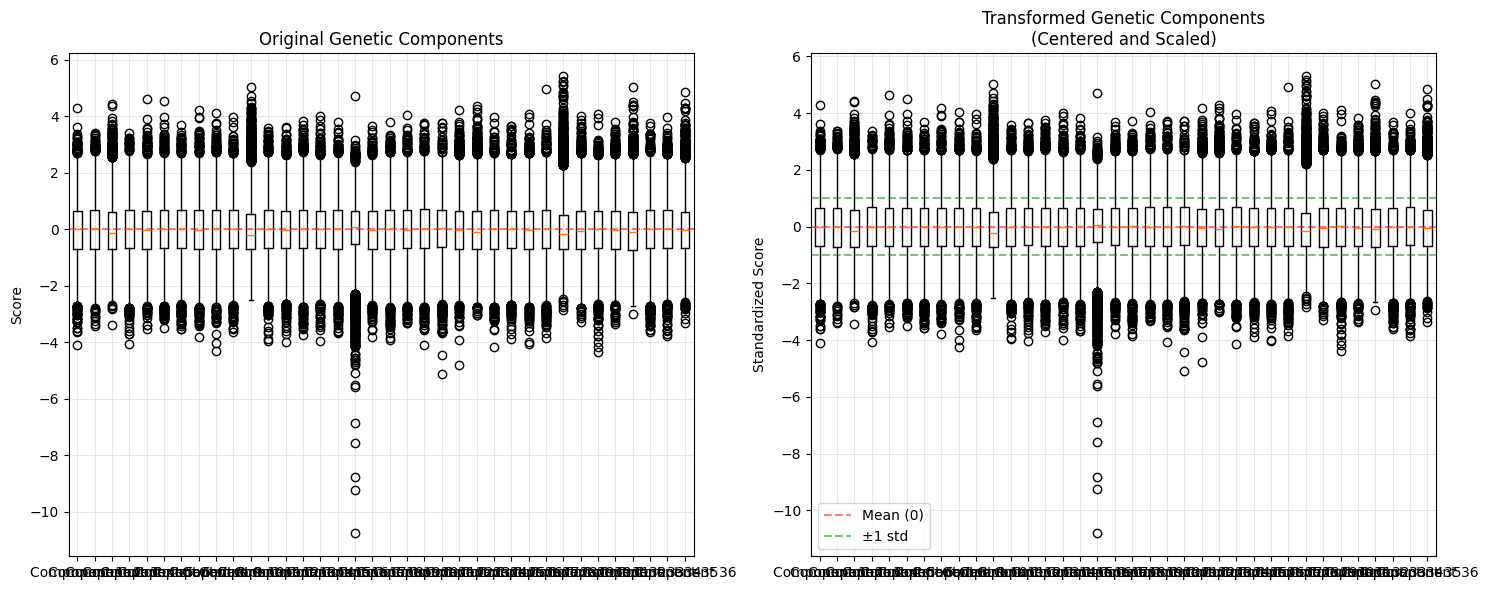


Genetic Components Summary Statistics:
Component  Original Mean Original Std  Trans. Mean  Trans. Std
------------------------------------------------------------
1                 -0.001        0.999        0.000       1.000
2                  0.011        1.003       -0.000       1.000
3                  0.012        0.994        0.000       1.000
4                  0.007        1.002       -0.000       1.000
5                 -0.007        0.994       -0.000       1.000
6                  0.008        1.006       -0.000       1.000
7                  0.031        0.994       -0.000       1.000
8                  0.003        1.009        0.000       1.000
9                  0.006        1.014        0.000       1.000
10                 0.012        0.999        0.000       1.000
11                 0.008        1.000       -0.000       1.000
12                 0.012        0.999       -0.000       1.000
13                -0.005        0.989       -0.000       1.000
14               

In [9]:

# Plot both versions:
model.plot_genetic_scores(original_G)
print(model.G[:,3].mean())

print(original_G[:,3].mean())


# Check G matrix scaling
G_mean = model.G.mean(dim=0)
G_std = model.G.std(dim=0)
print("\nG matrix scaling check:")
print(f"Mean should be ~0: {G_mean.abs().max().item():.6f}")
print(f"Std should be ~1: {(G_std - 1).abs().max().item():.6f}")



In [10]:
initial_gamma = model.gamma.detach().clone()
initial_phi = model.phi.detach().clone()
initial_lambda = model.lambda_.detach().clone()
initial_psi = model.psi.detach().clone()


In [11]:

history = model.fit(E_100k, num_epochs=2, learning_rate=1e-4, lambda_reg=1e-2)
        

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g_logit_init_acceptpsi.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)


mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 0
Loss: 1107.0331
Psi gradient stats:
Mean: -2.1786e-05
Std:  4.7510e-03
Max:  1.6340e-02
Min:  -2.0144e-02
Epoch 0, Loss: 1107.0331, Gradients - Lambda: 5.545e-01, Phi: 1.513e+01, Gamma: 5.400e-02, Psi: 2.014e-02
mask_before_event shape: torch.Size([10000, 348, 52])
mask_at_event shape: torch.Size([10000, 348, 52])

Epoch 1
Loss: 960.4230
Psi gradient stats:
Mean: -2.2020e-05
Std:  4.7429e-03
Max:  1.6305e-02
Min:  -2.0080e-02
Epoch 1, Loss: 960.4230, Gradients - Lambda: 5.296e-01, Phi: 1.442e+01, Gamma: 5.334e-02, Psi: 2.008e-02

Estimated total training time: 1.2 minutes


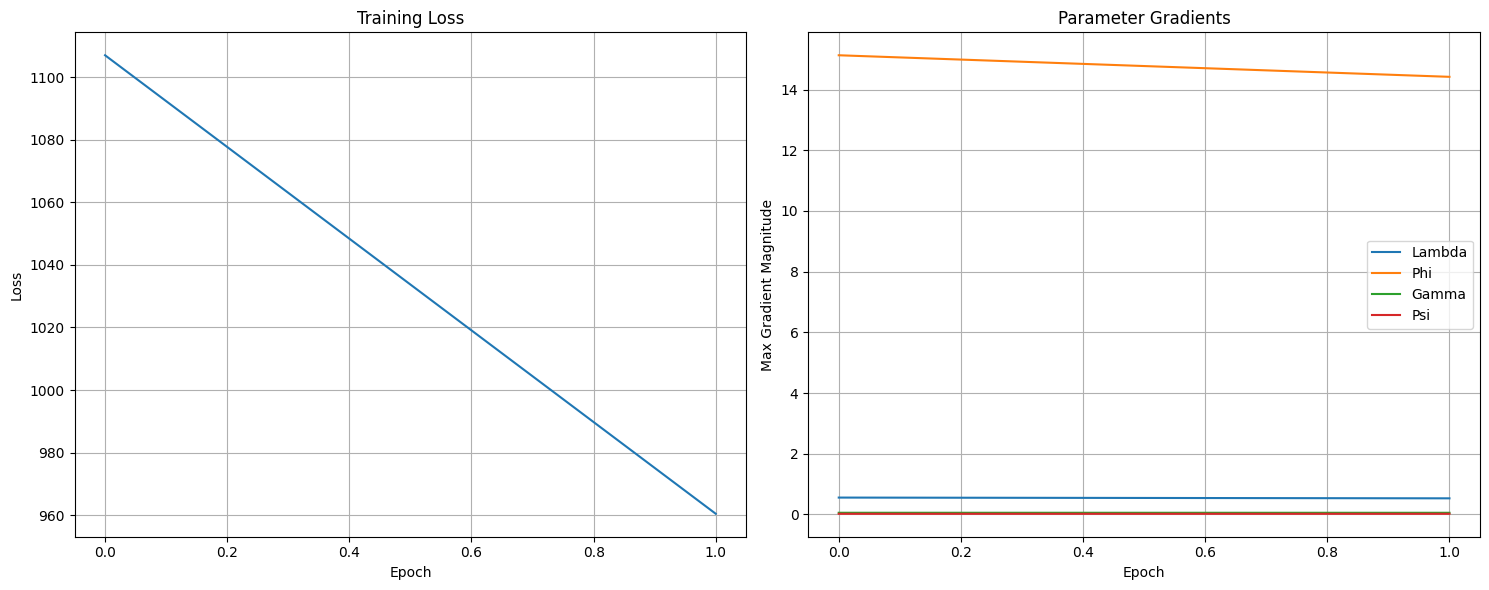

In [12]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history['max_grad_lambda'], label='Lambda')
ax2.plot(history['max_grad_phi'], label='Phi')
ax2.plot(history['max_grad_gamma'], label='Gamma')
ax2.plot(history['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [13]:
disease_names=essentials['disease_names']

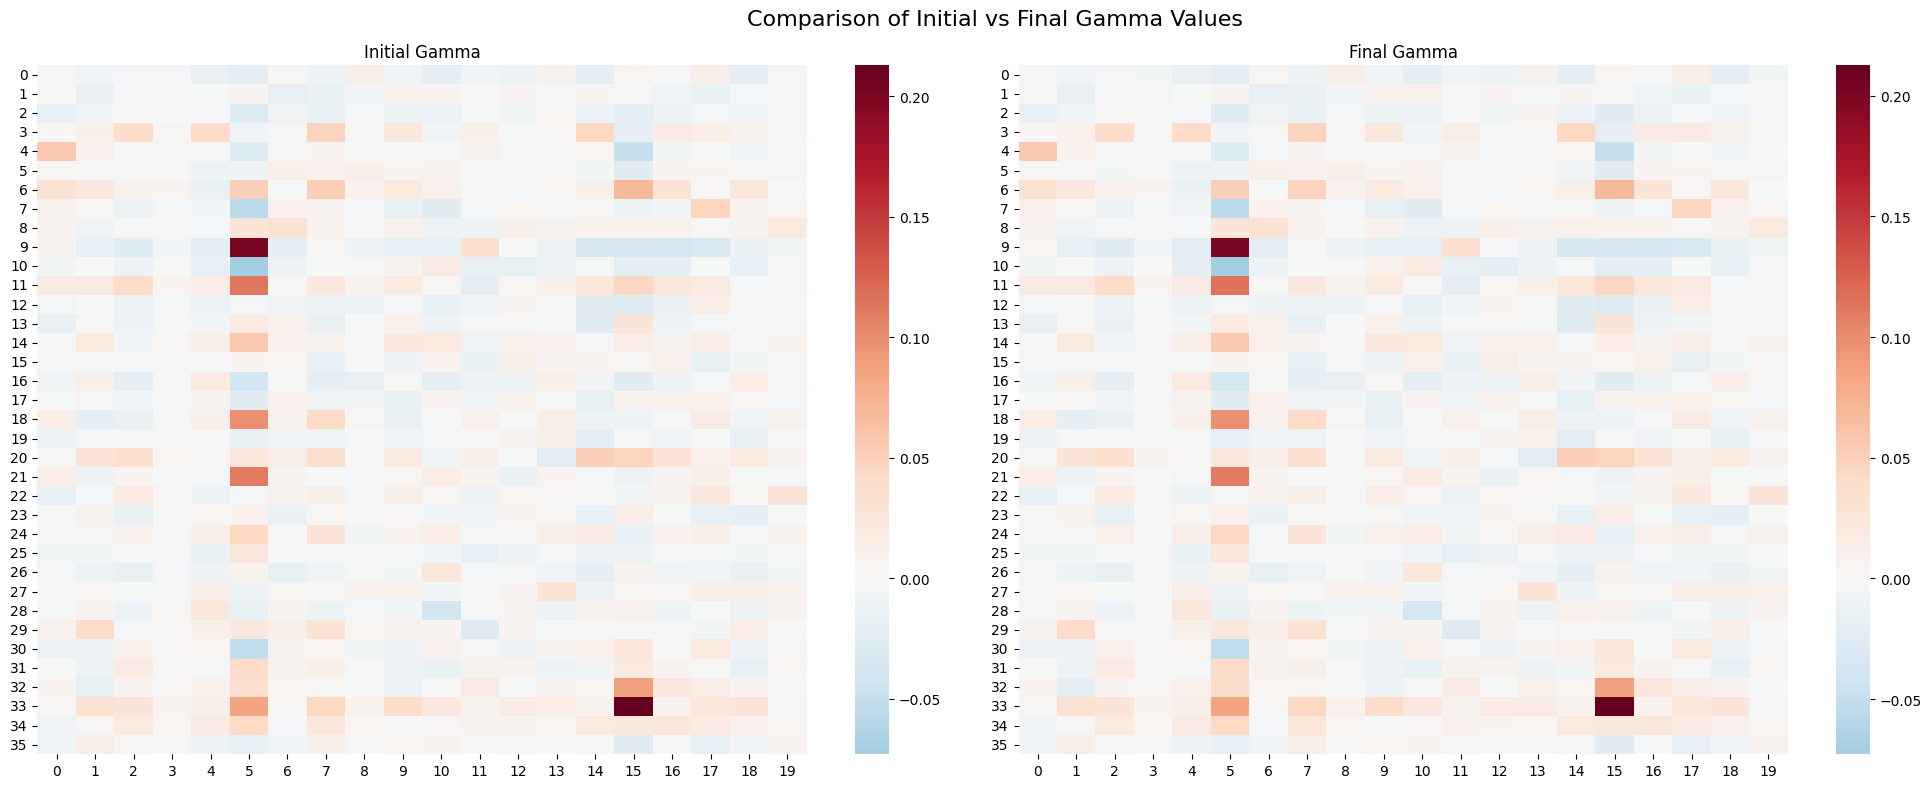

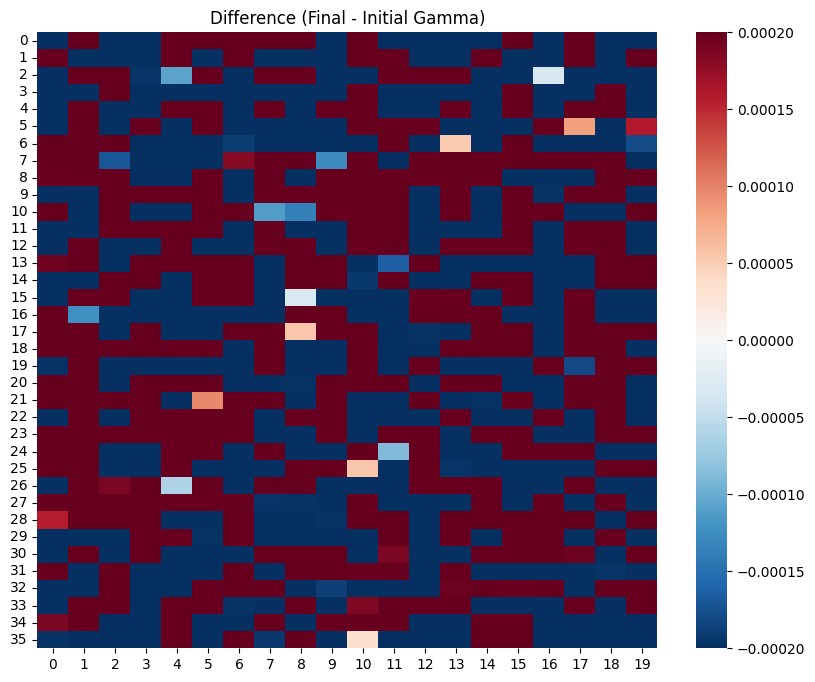

Mean absolute difference: 0.0002
Max absolute difference: 0.0002
Standard deviation of differences: 0.0002


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert gamma tensors to numpy arrays
initial_gamma_np = initial_gamma.detach().numpy()
final_gamma_np = model.gamma.detach().numpy()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial gamma
sns.heatmap(initial_gamma_np, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Gamma')

# Plot final gamma
sns.heatmap(final_gamma_np, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Gamma')

# Add a title to the figure
plt.suptitle('Comparison of Initial vs Final Gamma Values', fontsize=16)

# You can also add a colorbar
plt.tight_layout()

# To see the actual difference, you can also create a difference heatmap
plt.figure(figsize=(10, 8))
diff = final_gamma_np - initial_gamma_np
sns.heatmap(diff, cmap='RdBu_r', center=0)
plt.title('Difference (Final - Initial Gamma)')
plt.show()

# Print some summary statistics
print(f"Mean absolute difference: {np.abs(diff).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff):.4f}")

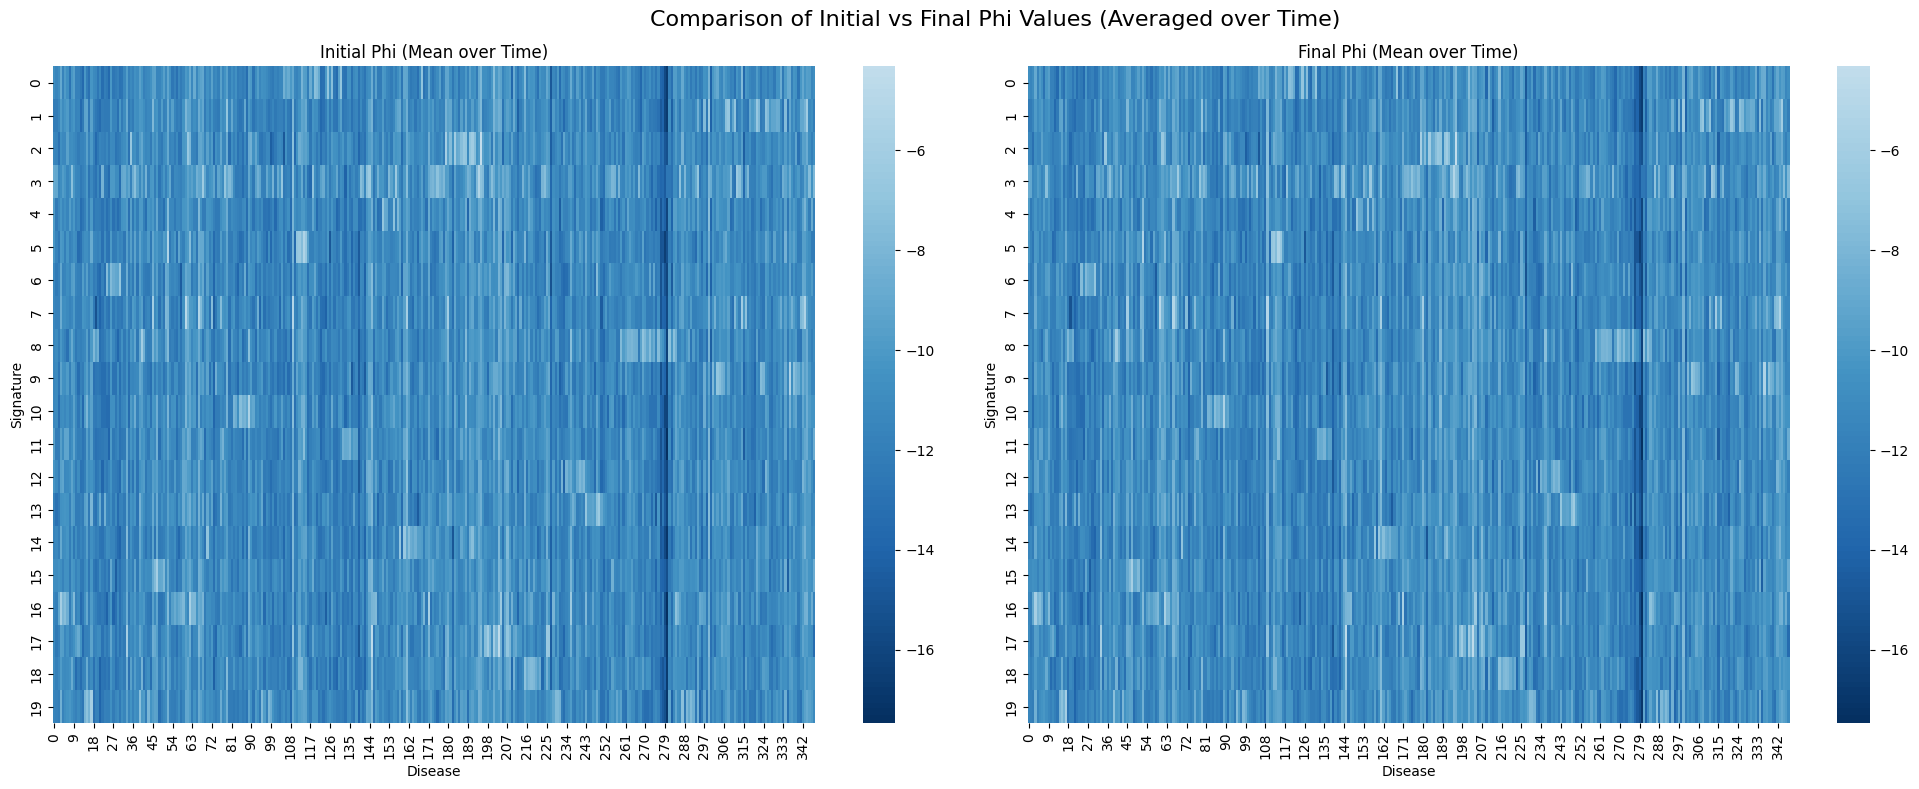

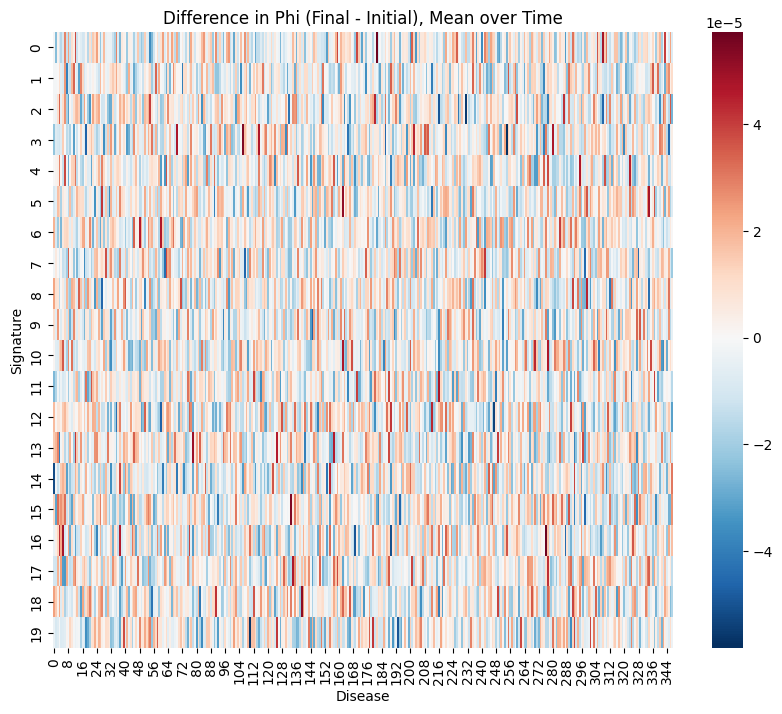

Full tensor statistics:
Mean absolute difference: 0.0002
Max absolute difference: 0.0002
Standard deviation of differences: 0.0002

Time-averaged statistics:
Mean absolute difference: 0.0000
Max absolute difference: 0.0001
Standard deviation of differences: 0.0000


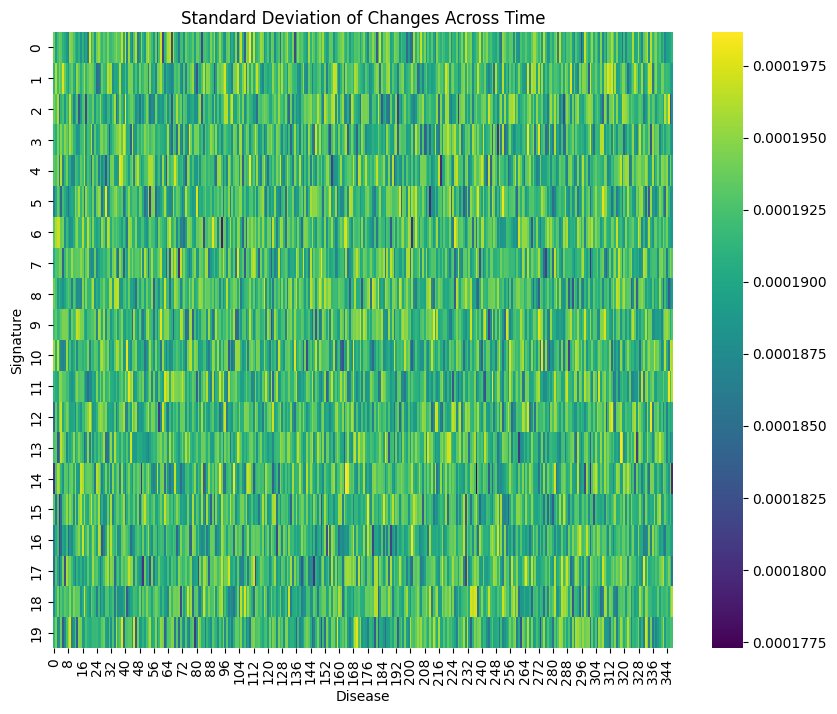

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert phi tensors to numpy arrays
initial_phi_np = initial_phi.detach().numpy()  # Shape: (K, D, T)
final_phi_np = model.phi.detach().numpy()

# Take mean over time dimension
initial_phi_mean = initial_phi_np.mean(axis=2)  # Shape: (K, D)
final_phi_mean = final_phi_np.mean(axis=2)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot initial phi (averaged over time)
sns.heatmap(initial_phi_mean, ax=ax1, cmap='RdBu_r', center=0)
ax1.set_title('Initial Phi (Mean over Time)')
ax1.set_xlabel('Disease')
ax1.set_ylabel('Signature')

# Plot final phi (averaged over time)
sns.heatmap(final_phi_mean, ax=ax2, cmap='RdBu_r', center=0)
ax2.set_title('Final Phi (Mean over Time)')
ax2.set_xlabel('Disease')
ax2.set_ylabel('Signature')

plt.suptitle('Comparison of Initial vs Final Phi Values (Averaged over Time)', fontsize=16)
plt.tight_layout()

# Plot difference
plt.figure(figsize=(10, 8))
diff_mean = final_phi_mean - initial_phi_mean
sns.heatmap(diff_mean, cmap='RdBu_r', center=0)
plt.title('Difference in Phi (Final - Initial), Mean over Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

# Print summary statistics for both full tensor and time-averaged differences
print("Full tensor statistics:")
diff_full = final_phi_np - initial_phi_np
print(f"Mean absolute difference: {np.abs(diff_full).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_full).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_full):.4f}")

print("\nTime-averaged statistics:")
print(f"Mean absolute difference: {np.abs(diff_mean).mean():.4f}")
print(f"Max absolute difference: {np.abs(diff_mean).max():.4f}")
print(f"Standard deviation of differences: {np.std(diff_mean):.4f}")

# Optionally, look at temporal variation
temporal_std = np.std(diff_full, axis=2)
plt.figure(figsize=(10, 8))
sns.heatmap(temporal_std, cmap='viridis')
plt.title('Standard Deviation of Changes Across Time')
plt.xlabel('Disease')
plt.ylabel('Signature')
plt.show()

In [16]:
Y_global=Y


In [17]:
Y_global.shape

torch.Size([407878, 348, 52])

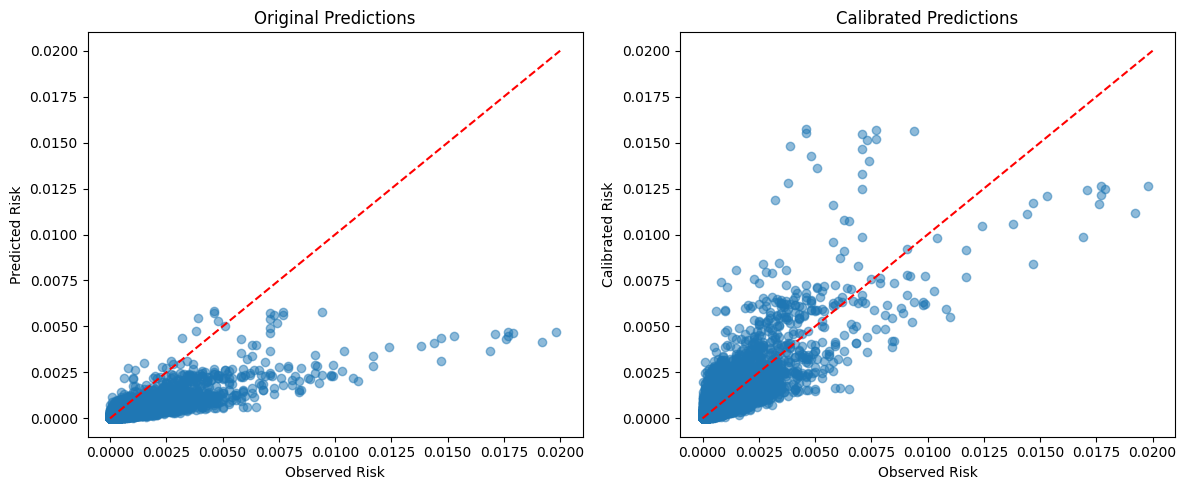

Mean observed risk: 0.000451
Mean predicted risk (original): 0.000167
Mean predicted risk (calibrated): 0.000451
Calibration scale factor: 2.700


In [18]:
# 1. Get predictions and actual values
predicted = model.forward()
pi_pred = predicted[0] if isinstance(predicted, tuple) else predicted
pi_pred = pi_pred.cpu().detach().numpy()
Y = model.Y.cpu().detach().numpy()

# 2. Calculate marginal risks directly
# Assuming dimensions are: [N, D, T] for both Y and pi_pred
observed_risk = Y.mean(axis=0).flatten()  # average across individuals
predicted_risk = pi_pred.mean(axis=0).flatten()

# 3. Apply calibration
scale_factor = np.mean(observed_risk) / np.mean(predicted_risk)
calibrated_risk = predicted_risk * scale_factor

# 4. Plot
plt.figure(figsize=(12, 5))

# Original predictions
plt.subplot(121)
plt.scatter(observed_risk, predicted_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Original Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Predicted Risk')

# Calibrated predictions
plt.subplot(122)
plt.scatter(observed_risk, calibrated_risk, alpha=0.5)
plt.plot([0, 0.02], [0, 0.02], 'r--')  # y=x line
plt.title('Calibrated Predictions')
plt.xlabel('Observed Risk')
plt.ylabel('Calibrated Risk')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean observed risk: {np.mean(observed_risk):.6f}")
print(f"Mean predicted risk (original): {np.mean(predicted_risk):.6f}")
print(f"Mean predicted risk (calibrated): {np.mean(calibrated_risk):.6f}")
print(f"Calibration scale factor: {scale_factor:.3f}")


In [19]:

ss_res = np.sum((observed_risk - calibrated_risk) ** 2)
ss_tot = np.sum((observed_risk - np.mean(observed_risk)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"R^2: {r2:.3f}")

R^2: 0.663


In [20]:
def plot_signature_top_diseases_centered(model, disease_names, n_top=10):
    """
    Show top diseases for each signature, centered relative to prevalence
    """
    # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # For each signature, get top diseases
    for k in range(phi_avg.shape[0]):
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        print(f"\nTop {n_top} diseases in Signature {k} (relative to baseline):")
        for idx in top_indices:
            avg_effect = scores[idx]
            temporal_std = np.std(phi_centered[k, idx, :])
            # Convert to odds ratio for interpretability
            odds_ratio = np.exp(avg_effect)
            print(f"{disease_names[idx]}: effect={avg_effect:.3f} (OR={odds_ratio:.2f}), std={temporal_std:.3f}")

# Run visualization
plot_signature_top_diseases_centered(model, essentials['disease_names'])


Top 10 diseases in Signature 0 (relative to baseline):
Rheumatic disease of the heart valves: effect=2.386 (OR=10.87), std=0.266
Pericarditis: effect=2.060 (OR=7.84), std=0.486
Paroxysmal supraventricular tachycardia: effect=1.899 (OR=6.68), std=0.267
Heart failure NOS: effect=1.798 (OR=6.04), std=0.251
Cardiomegaly: effect=1.796 (OR=6.03), std=0.451
Congenital anomalies of great vessels: effect=1.318 (OR=3.74), std=0.810
Other forms of chronic heart disease: effect=1.302 (OR=3.68), std=0.287
Primary/intrinsic cardiomyopathies: effect=1.204 (OR=3.33), std=0.454
Aortic valve disease: effect=1.199 (OR=3.32), std=0.539
Pleurisy; pleural effusion: effect=1.177 (OR=3.24), std=0.730

Top 10 diseases in Signature 1 (relative to baseline):
Synovitis and tenosynovitis: effect=1.810 (OR=6.11), std=0.484
Hallux valgus (Bunion): effect=1.696 (OR=5.45), std=0.923
Other acquired deformities of limbs: effect=1.491 (OR=4.44), std=0.660
Osteoarthritis; localized: effect=1.230 (OR=3.42), std=0.534
Inte

In [21]:
def compare_disease_rankings(model, disease_names, n_top=10):
    """
    Compare initial vs final disease rankings for each signature
    """
    # Get initial rankings from psi
    psi = model.psi.detach().numpy()  # Shape: (K, D)
    
    # Get final rankings from centered phi
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Compare rankings for each signature
    for k in range(phi_avg.shape[0]):
        print(f"\nSignature {k}:")
        
        # Get initial top diseases from psi
        initial_scores = psi[k, :]
        initial_top = np.argsort(initial_scores)[-n_top:][::-1]
        
        # Get final top diseases from phi
        final_scores = phi_avg[k, :]
        final_top = np.argsort(final_scores)[-n_top:][::-1]
        
        print("\nInitial top diseases:")
        for i, idx in enumerate(initial_top):
            print(f"{i+1}. {disease_names[idx]}: {initial_scores[idx]:.3f}")
            
        print("\nFinal top diseases:")
        for i, idx in enumerate(final_top):
            print(f"{i+1}. {disease_names[idx]}: {final_scores[idx]:.3f}")
            
        # Calculate rank changes
        initial_ranks = {disease: rank for rank, disease in enumerate(initial_top)}
        final_ranks = {disease: rank for rank, disease in enumerate(final_top)}
        
        # Find diseases that changed ranks significantly
        changed_diseases = set(initial_top) | set(final_top)
        for disease in changed_diseases:
            initial_rank = initial_ranks.get(disease, n_top+1)
            final_rank = final_ranks.get(disease, n_top+1)
            if abs(final_rank - initial_rank) > 2:  # Threshold for significant change
                print(f"\n{disease_names[disease]} changed from rank {initial_rank+1} to {final_rank+1}")

# Run comparison
compare_disease_rankings(model, essentials['disease_names'])


Signature 0:

Initial top diseases:
1. Aortic valve disease: 1.180
2. Heart failure NOS: 1.147
3. Paroxysmal ventricular tachycardia: 1.106
4. Left bundle branch block: 1.072
5. Congestive heart failure (CHF) NOS: 1.044
6. Congenital anomalies of great vessels: 1.033
7. Atrial fibrillation and flutter: 1.028
8. Pericarditis: 1.004
9. Cardiomegaly: 0.999
10. Mitral valve disease: 0.982

Final top diseases:
1. Rheumatic disease of the heart valves: 2.386
2. Pericarditis: 2.060
3. Paroxysmal supraventricular tachycardia: 1.899
4. Heart failure NOS: 1.798
5. Cardiomegaly: 1.796
6. Congenital anomalies of great vessels: 1.318
7. Other forms of chronic heart disease: 1.302
8. Primary/intrinsic cardiomyopathies: 1.204
9. Aortic valve disease: 1.199
10. Pleurisy; pleural effusion: 1.177

Congestive heart failure (CHF) NOS changed from rank 5 to 12

Rheumatic disease of the heart valves changed from rank 12 to 1

Aortic valve disease changed from rank 1 to 9

Other forms of chronic heart disea

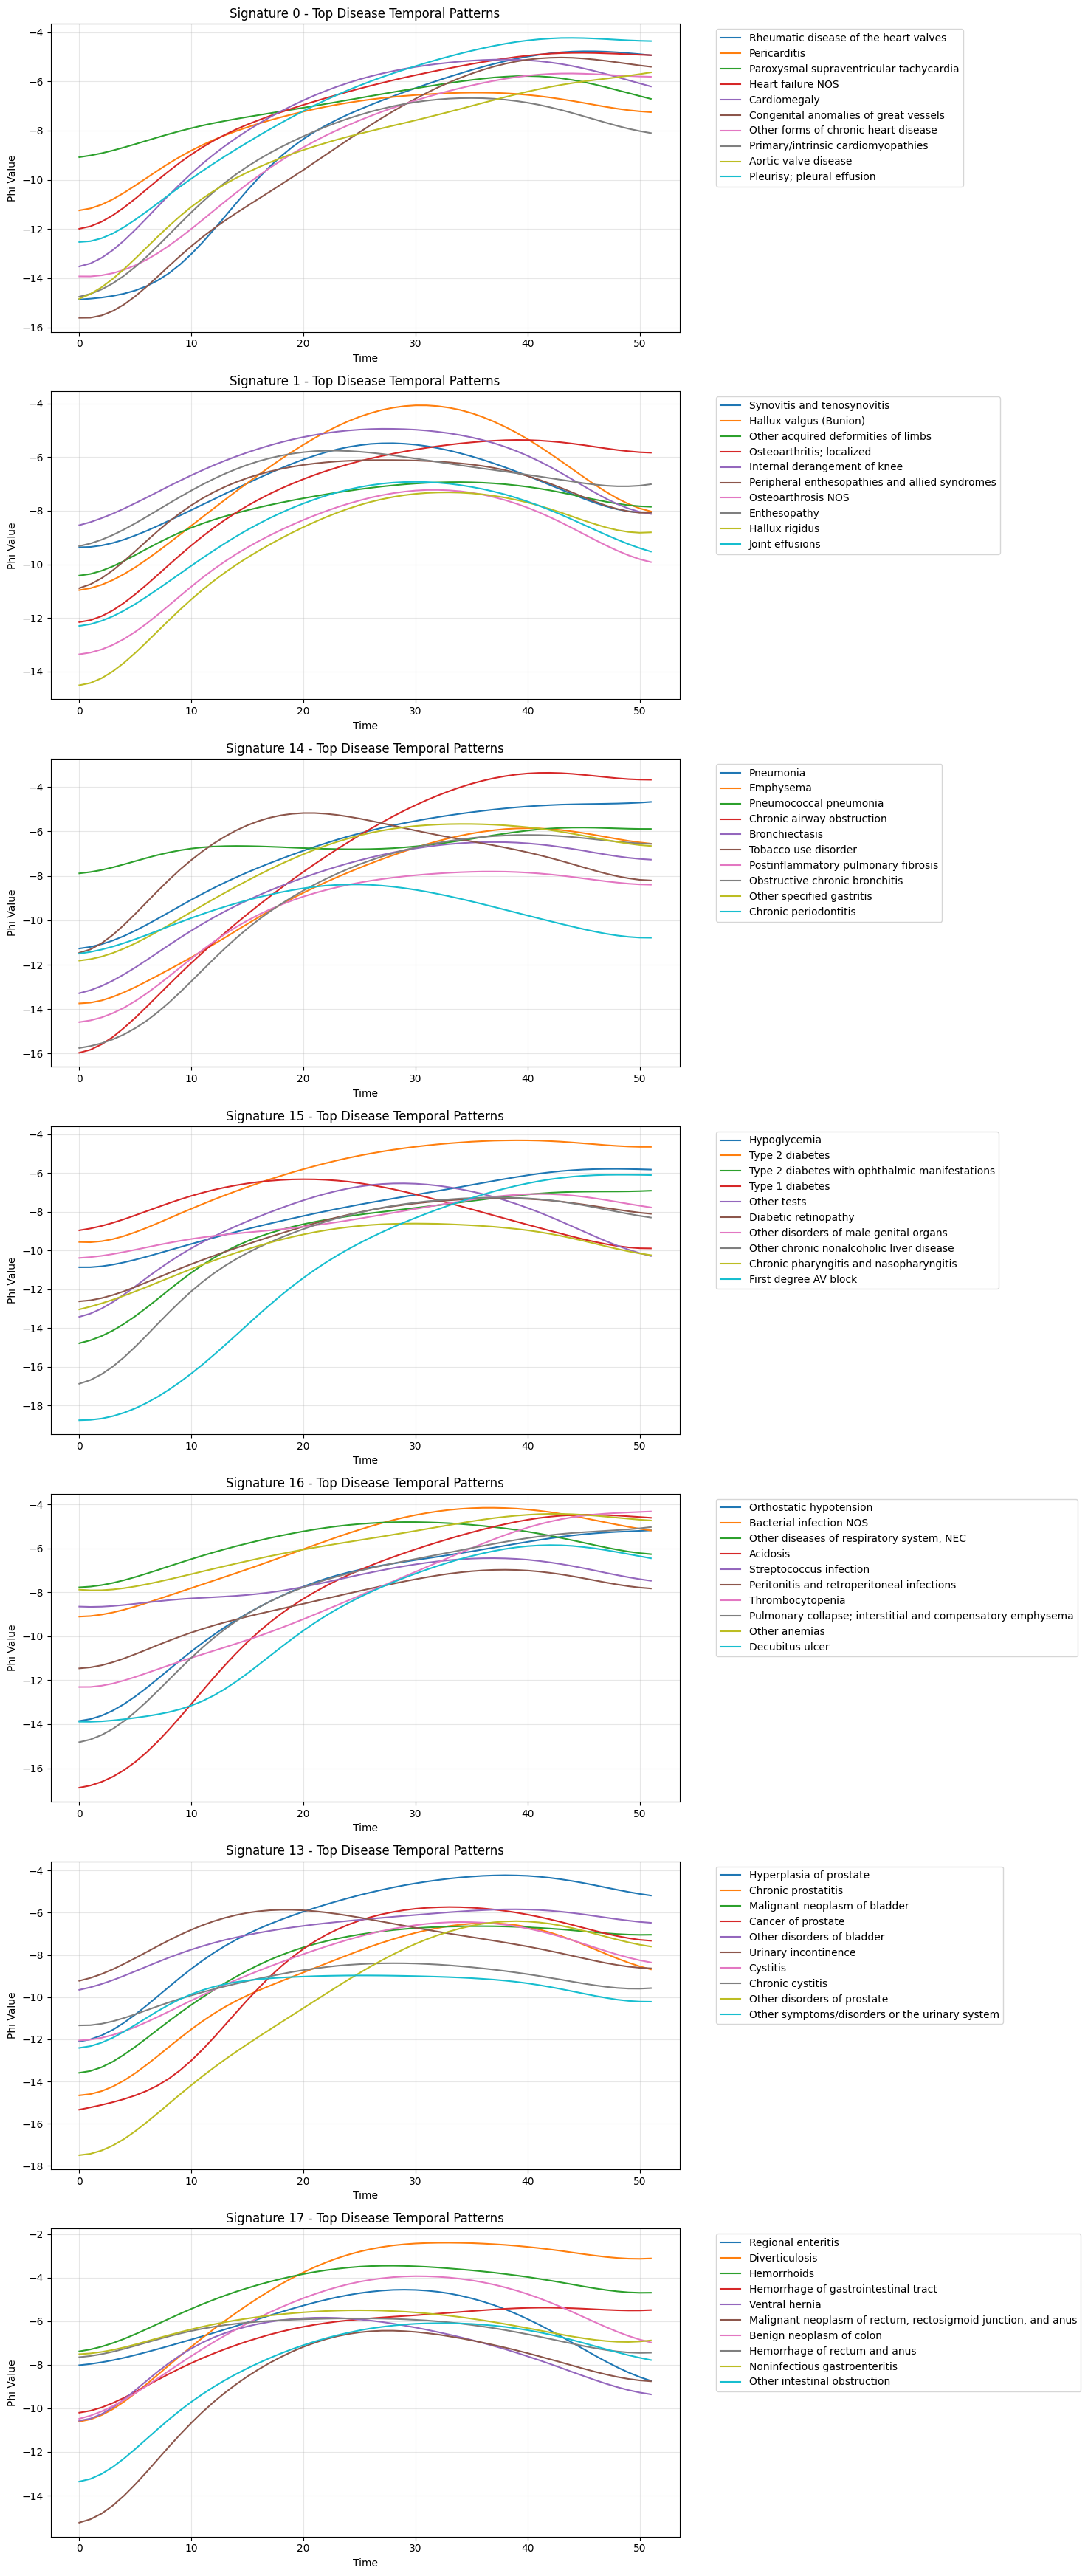

In [23]:
def plot_signature_temporal_patterns(model, disease_names, n_top=10, selected_signatures=None):
    """
    Show temporal patterns of top diseases for each signature
    """
    #phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    #phi_avg = phi.mean(axis=2)  # Average over time

     # Get phi and prevalence
    phi = model.phi.detach().numpy()  # Shape: (K, D, T)
    prevalence_logit = model.logit_prev_t.detach().numpy()  # Shape: (D, T)
    
    # Center phi relative to prevalence
    phi_centered = np.zeros_like(phi)
    for k in range(phi.shape[0]):
        for d in range(phi.shape[1]):
            phi_centered[k, d, :] = phi[k, d, :] - prevalence_logit[d, :]
    
    # Average over time
    phi_avg = phi_centered.mean(axis=2)  # Shape: (K, D)
    
    # Select which signatures to plot
    if selected_signatures is None:
        selected_signatures = range(phi_avg.shape[0])
    
    # Create subplots for each selected signature
    n_sigs = len(selected_signatures)
    fig, axes = plt.subplots(n_sigs, 1, figsize=(15, 5*n_sigs))
    if n_sigs == 1:
        axes = [axes]
    
    for i, k in enumerate(selected_signatures):
        # Get top diseases
        scores = phi_avg[k, :]
        top_indices = np.argsort(scores)[-n_top:][::-1]
        
        # Plot temporal patterns
        ax = axes[i]
        for idx in top_indices:
            temporal_pattern = phi[k, idx, :]
            ax.plot(temporal_pattern, label=disease_names[idx])
        
        ax.set_title(f'Signature {k} - Top Disease Temporal Patterns')
        ax.set_xlabel('Time')
        ax.set_ylabel('Phi Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# First show the top diseases


# Then show their temporal patterns
# You can select specific signatures of interest:
disease_names=essentials['disease_names']
plot_signature_temporal_patterns(model, disease_names, selected_signatures=[0,1,14,15,16,13,17])

In [25]:
Y_avg_global = torch.mean(torch.tensor(Y_global) if isinstance(Y_global, np.ndarray) else Y_global, dim=2)
Y_avg_batch = torch.mean(torch.tensor(Y_100k) if isinstance(Y_100k, np.ndarray) else Y_100k, dim=2)


In [26]:
def compare_disease_patterns(k, true_psi, Y_avg_global, Y_avg_batch):
    """Compare disease patterns between global and batch data"""
    strong_diseases = (true_psi[k] > 0)
    
    # Get mean pattern for each dataset (average across patients)
    pattern_large = Y_avg_global[:, strong_diseases].mean(dim=0)  # Average across all patients
    pattern_small = Y_avg_batch[:, strong_diseases].mean(dim=0)  # Average across batch patients
    
    # Now both patterns are just length of strong_diseases
    correlation = torch.corrcoef(
        torch.stack([pattern_large, pattern_small])
    )[0,1]
    
    print(f"Signature {k} pattern correlation: {correlation:.3f}")
    print(f"Mean pattern difference: {(pattern_large - pattern_small).abs().mean():.3f}")

# Now use it
print("Comparing disease sharing patterns between global and batch data:")
for k in range(model.K):
    print(f"\nSignature {k}:")
    compare_disease_patterns(k, model.psi, Y_avg_global, Y_avg_batch)

Comparing disease sharing patterns between global and batch data:

Signature 0:
Signature 0 pattern correlation: 0.999
Mean pattern difference: 0.000

Signature 1:
Signature 1 pattern correlation: 1.000
Mean pattern difference: 0.000

Signature 2:
Signature 2 pattern correlation: 0.999
Mean pattern difference: 0.000

Signature 3:
Signature 3 pattern correlation: 0.996
Mean pattern difference: 0.000

Signature 4:
Signature 4 pattern correlation: 0.982
Mean pattern difference: 0.000

Signature 5:
Signature 5 pattern correlation: 1.000
Mean pattern difference: 0.000

Signature 6:
Signature 6 pattern correlation: 0.992
Mean pattern difference: 0.000

Signature 7:
Signature 7 pattern correlation: 1.000
Mean pattern difference: 0.000

Signature 8:
Signature 8 pattern correlation: 0.995
Mean pattern difference: 0.000

Signature 9:
Signature 9 pattern correlation: 0.996
Mean pattern difference: 0.000

Signature 10:
Signature 10 pattern correlation: 0.999
Mean pattern difference: 0.000

Signatu